# Geocoding 

**Credit:**

[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  

Geocoding is the process of transforming place names or addresses into coordinates. In this lesson we will learn how to geocode addresses using Geopandas and [geopy](https://geopy.readthedocs.io/en/stable/).

Geopy and other geocoding libaries (such as [geocoder](http://geocoder.readthedocs.io/))
make it easy to locate the coordinates of addresses, cities, countries, and landmarks across the globe using web services ("geocoders"). In practice, geocoders are often Application Programming Interfaces (APIs) where you can send requests, and receive responses in the form of place names, addresses and coordinates.

Geopy offers access to several geocoding services, including:

* [ESRI ArcGIS](https://developers.arcgis.com/rest/geocode/api-reference/overview-world-geocoding-service.htm)
* [Baidu Maps](http://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding)
* [Bing](https://msdn.microsoft.com/en-us/library/ff701715.aspx)
* [GeocodeFarm](https://www.geocode.farm/geocoding/free-api-documentation/)
* [GeoNames](http://www.geonames.org/export/geonames-search.html)
* [Google Geocoding API (V3)](https://developers.google.com/maps/documentation/geocoding/)
* [HERE](https://developer.here.com/documentation/geocoder/)
* [IGN France](https://geoservices.ign.fr/documentation/geoservices/index.html)
* [Mapquest](https://developer.mapquest.com/documentation/open/)
* [OpenCage](https://opencagedata.com/api)
* [OpenMapQuest](http://developer.mapquest.com/web/products/open/geocoding-service)
* [Open Street Map Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim)
* [What3words](https://developer.what3words.com/public-api/docsv2#overview)
* [Yandex](https://tech.yandex.com/maps/doc/geocoder/desc/concepts/input_params-docpage/)

Check the [geopy documentation](https://geopy.readthedocs.io/en/stable/) for more details about how to use each service via Python.

As you see, there are plenty of geocoders where to choose from! The quality of the geocoders might differ depending on the underlying data. For example, some addresses might exists on OpenStreetMap, but not on Google Maps and thus they can be geocoded using the Nominatim geocoder, but not using the Google Geocoding API - and vice versa.

Geocoding services might require an **API key** in order to use them. (i.e. you need to register for the service before you can access results from their API). Furthermore, **rate limiting** also restrict the use of these services. The geocoding process might end up in an error if you are making too many requests in a short time period (eg. trying to geocode large number of addresses). See hints for dealing with rate limiting when geocoding pandas DataFrames from the [geopy documentation](https://geopy.readthedocs.io/en/stable/).
If you pay for the geocoding service, you can naturally make more requests to the API.

In this lesson we will use the Nominatim geocoder for locating a relatively small number of addresses. Usage of the Nominatim geocoding service is rate-limited to 1 request per second (3600 / hour). You can read more about Nominatim usage policy [here](https://operations.osmfoundation.org/policies/nominatim/).

Luckily, Nominatim, which is a geocoder based on OpenStreetMap data does not require a API key to use their service
if it is used to geocode only a small number of addresses.


**NOTE**

As per [geopy documentation for the Nominatim geocoder](https://geopy.readthedocs.io/en/stable/#nominatim) we need to specify a custom `user_agent` parameter when making requests not to violate the Nominatim Usage Policy.


## Geocoding in Geopandas

It is possible to do [geocoding in Geopandas](http://geopandas.org/geocoding.html) through geopy. Geopandas has a function called `geocode()` that can geocode a list of addresses (strings) and return a GeoDataFrame containing the resulting point objects in ``geometry`` column. 

Let's try this out.

We will geocode addresses stored in a text file called `addresses.txt`. These addresses are located in the Helsinki Region in Southern Finland.

The first rows of the data look like this:

```
id;addr
1000;Itämerenkatu 14, 00101 Helsinki, Finland
1001;Kampinkuja 1, 00100 Helsinki, Finland
1002;Kaivokatu 8, 00101 Helsinki, Finland
1003;Hermannin rantatie 1, 00580 Helsinki, Finland
```

We have an `id` for each row and an address on column `addr`.

Let's first read the data into a Pandas DataFrame using the `read_csv()` -function:

In [2]:
# Import necessary modules
import os

import geopandas as gpd
import pandas as pd

from shapely.geometry import Point
from geopandas.tools import geocode


In [3]:
# Filepath
fp = ["..", "data", "Addresses", "addresses.txt"]
input_file = os.path.join(*fp)

# Read the data
data = pd.read_csv(input_file, sep=";")

Let's check that we imported the file correctly:

In [4]:
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


## Geocode addresses using Nominatim

Now we have our data in a pandas DataFrame and we can geocode our addresses using the [geopandas geocoding function](http://geopandas.org/reference/geopandas.tools.geocode.html#geopandas-tools-geocode) that uses `geopy` package in the background. 

- Let's import the geocoding function and geocode the addresses (column `addr`) using Nominatim. 
- Remember to provide a custom string (name of your application) in the `user_agent` parameter.
- If needed, you can add the `timeout`-parameter which specifies how many seconds we will wait for a response from the service.

In [7]:
# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
geo = geocode(data['addr'], provider='nominatim', user_agent='gis-training-kevin', timeout=30)

<AxesSubplot:>

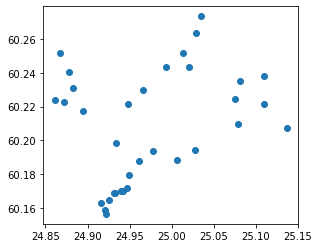

In [14]:
# geo.head()
geo.plot()

And Voilà! As a result we have a GeoDataFrame that contains our original
address and a 'geometry' column containing Shapely Point -objects that
we can use for exporting the addresses to a Shapefile for example.
However, the ``id`` column is not there. Thus, we need to join the
information from ``data`` into our new GeoDataFrame ``geo``, thus making
a **Table Join**.

<div class="alert alert-info">

**Rate-limiting**

When geocoding a large dataframe, you might encounter an error when geocoding. In case you get a time out error, try first using the `timeout` parameter as we did above (allow the service a bit more time to respond). In case of Too Many Requests error, you have hit the rate-limit of the service, and you should slow down your requests. To our convenience, geopy provides additional tools for taking into account rate limits in geocoding services. This script adapts the usage of [geopy RateLimiter](https://geopy.readthedocs.io/en/stable/#geopy.extra.rate_limiter.RateLimiter) to our input data:

```
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point

# Initiate geocoder
geolocator = Nominatim(user_agent='gis_training')

# Create a geopy rate limiter:
geocode_with_delay = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Apply the geocoder with delay using the rate limiter:
data['temp'] = data['addr'].apply(geocode_with_delay)

# Get point coordinates from the GeoPy location object on each row:
data["coords"] = data['temp'].apply(lambda loc: tuple(loc.point) if loc else None)

# Create shapely point objects to geometry column:
data["geometry"] = data["coords"].apply(Point)
```
All in all, remember that Nominatim is not meant for super heavy use. 
</div>


## Table join
<div class="alert alert-info">

**Table joins in pandas**
    
For a comprehensive overview of different ways of combining DataFrames and Series based on set theory, have a look at pandas documentation about [merge, join and concatenate](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).


</div>


Table joins are really common procedures when doing GIS analyses. Combining data from different tables based on common
**key** attribute can be done easily in pandas/geopandas using the [merge()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) -function.

However, sometimes it is useful to join two tables together based on the **index** of those DataFrames. In such case, we assume
that there is **same number of records** in our DataFrames and that the **order of the records should be the same** in both DataFrames.

We can use this approach to join information from the original data to our geocoded addresses row-by-row 
``join()`` -function which merges the two DataFrames together
based on index by default. This approach works correctly because the order of the geocoded addresses in ``geo`` DataFrame is the same as in our original ``data`` DataFrame.

In [9]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93169 60.16902),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97759 60.19361),"Hermannin rantatie, Hermanninmäki, Hermanni, K...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


Let's also check the data type of our new ``join`` table.

In [10]:
type(join)

geopandas.geodataframe.GeoDataFrame

As a result we have a new GeoDataFrame called ``join`` where we now have
all original columns plus a new column for ``geometry``. **Note!** If you would do the join the other way around, i.e. `data.join(geo)`, the output would be a pandas DataFrame, not a GeoDataFrame!



Now it is easy to save our address points into a Shapefile

In [11]:
# Output file path
fp = ["..", "data", "Addresses", "addresses.shp"]
out_file = os.path.join(*fp)

# Save to Shapefile
join.to_file(out_file)

That's it. Now we have successfully geocoded those addresses into Points
and made a Shapefile out of them. Easy isn't it!

### Notes about Nominatim

Nominatim works relatively nicely if you have well defined and well-known addresses such as the ones that we used in this tutorial. In practice, the address needs to exist in the OpenStreetMap database. Sometimes, however, you might want to geocode a "point-of-interest", such as a museum, only based on it's name. If the museum name is not on OpenStreetMap, Nominatim won't provide any results for it, but you might be able to geocode the place using some other geocoder such as the [Google Geocoding API (V3)](https://developers.google.com/maps/documentation/geocoding/), which requires an API key.